# **Predicting tip ammount from NYC taxi data**

## Data exploration and cleaning

First of all, we are going to explore de data for seeking issues on it.

### Dependencies

In [1]:
!pip install PyDrive

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# load datasets from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Enable inline plotting
%matplotlib inline

### 1. Downloading datasets from google drive and reading CSV

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
tripdata_down = drive.CreateFile({'id': '1NiY1_U0HYDSclaaGRWpJqOJIvnWwTbxl'})
tripdata_down.GetContentFile('data_030611.csv')

In [0]:
data = pd.read_csv('data_030611.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
#data = pd.Series.from_csv('yellow_tripdata_2017-030611.csv', nrows=5000000, parse_dates=True, index_col=1)
data = data.fillna(np.nan)

### 2. Data exploration

We cannot use the DataFrame as Time Series due to there are tpep_pickup_datetime duplicated. This is because we don't have observations about just one event but a lot of then (for each taxi car).  We are going to analyze each attribute in order to identify issues with the data and document it.

In [5]:
print(data.shape)
data.head()

(6000000, 17)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-11-05 23:15:41,2017-11-05 23:22:08,6,1.42,1,N,143,141,1,7.0,0.5,0.5,1.66,0.0,0.3,9.96
1,1,2017-03-04 18:25:32,2017-03-04 18:36:17,1,1.10,1,N,158,113,1,8.0,0.0,0.5,1.75,0.0,0.3,10.55
2,2,2017-06-03 14:16:15,2017-06-03 14:39:52,1,3.19,1,N,163,211,2,16.5,0.0,0.5,0.00,0.0,0.3,17.30
3,2,2017-06-04 16:16:41,2017-06-04 16:23:34,1,1.43,1,N,90,231,2,7.5,0.0,0.5,0.00,0.0,0.3,8.30
4,1,2017-03-04 17:45:09,2017-03-04 18:08:31,1,3.50,1,N,87,186,1,16.5,0.0,0.5,3.45,0.0,0.3,20.75


#### Vendor ID

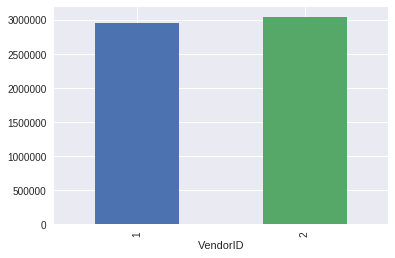

In [6]:
data.groupby('VendorID').size().plot(kind='bar')

No issues with Vendor ID because there are just two different vendors.

#### Passengers

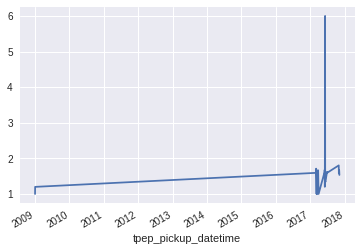

In [7]:
data.set_index('tpep_pickup_datetime')['passenger_count'].resample('D').mean().dropna().plot()

We can see there are data with a mistake in the pick up datetime. 

In [8]:
data[(data['tpep_pickup_datetime'] < '2017-01-01') | (data['tpep_pickup_datetime'] > '2017-12-31')]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
1553700,2,2008-12-31 17:48:27,2008-12-31 17:57:27,1,0.90,1,N,162,264,2,7.5,1.0,0.5,0.00,0.0,0.3,9.30
2141603,2,2009-01-01 00:26:27,2009-01-01 00:39:28,1,0.69,1,N,230,163,1,9.0,0.0,0.5,1.96,0.0,0.3,11.76
3497187,2,2009-01-01 00:51:57,2009-01-01 01:06:10,1,1.86,1,N,161,236,1,10.5,0.0,0.5,2.26,0.0,0.3,13.56
3566862,2,2009-01-01 01:34:54,2009-01-01 01:43:15,2,1.59,1,N,226,7,1,8.0,1.0,0.5,2.94,0.0,0.3,12.74
4494398,2,2008-12-31 23:18:19,2009-01-01 00:02:26,1,4.02,1,N,12,186,1,28.0,0.0,0.5,5.76,0.0,0.3,34.56
4618463,2,2009-01-01 00:05:09,2009-01-01 00:17:04,1,1.36,1,N,186,230,1,9.0,0.0,0.5,1.96,0.0,0.3,11.76
5831066,2,2009-01-01 00:42:17,2009-01-01 00:47:32,1,0.21,2,N,237,163,2,52.0,0.0,0.5,0.00,0.0,0.3,52.80


This data could be a meter or dataset mistake. Anyway they are outliers and they are not representative so we remove them.

In [0]:
data = data[(data['tpep_pickup_datetime'] > '2016-12-31') & (data['tpep_pickup_datetime'] < '2018-01-01')]

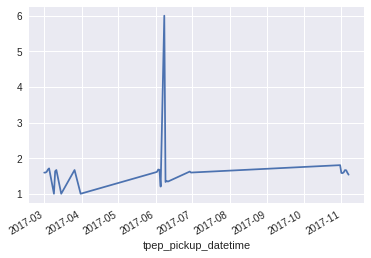

In [10]:
data.set_index('tpep_pickup_datetime')['passenger_count'].resample('D').mean().dropna().plot()

As we can see there are trips where the number of passengers is 0. As the dictionary says, it's an information given by the taxi driver so they could did some mistakes. We'll take a look at the total amount and the trip distance:

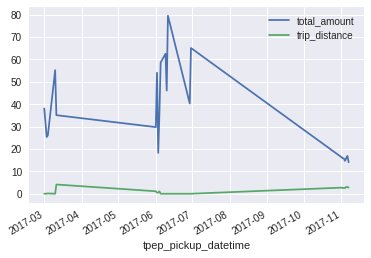

In [11]:
no_passengers = data[data['passenger_count'] == 0]
no_passengers.set_index('tpep_pickup_datetime')[['total_amount', 'trip_distance']].resample('D').mean().dropna().plot()

We'll just remove that rows where the number of passengers is 0 and the trip_distance is 0 and put passengers to 1 where trip_distance or total_amount are greater than 0. We should apply cluster techinques in order to segment by passenger_counts and get information about how many passengers paid a total amount but we are out of time. 

In [0]:
data = data[(data['passenger_count'] != 0) | (data['trip_distance'] != 0)]

We put **passenger_count** to 1 because is the minimun of passengers who paid:



In [0]:
data['passenger_count'] = data['passenger_count'].apply(lambda x: max(x, 1))

#### Trip distance

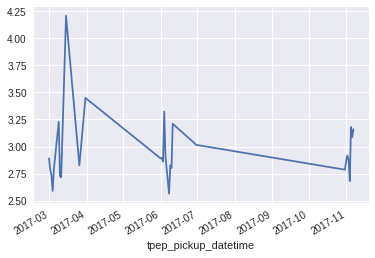

In [14]:
data.set_index('tpep_pickup_datetime')['trip_distance'].resample('D').mean().dropna().plot()

In [15]:
data['trip_distance'].describe()

count    5.999641e+06
mean     2.879870e+00
std      3.653986e+00
min      0.000000e+00
25%      9.900000e-01
50%      1.630000e+00
75%      3.010000e+00
max      5.985000e+02
Name: trip_distance, dtype: float64

There are trips with distance 0 and it makes no sense. We'll take a look to these trips

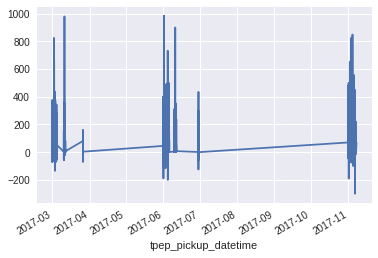

In [16]:
no_distance = data[data['trip_distance'] == 0]
no_distance.set_index('tpep_pickup_datetime')['total_amount'].plot()

There are trips with no distance but total amount paid by the passengers. We'll remove rows which total amount charged and the trip distance are 0. The reason may be the taxi driver did a favor for their friend or their family.

In [0]:
data = data[(data['total_amount'] != 0) | (data['trip_distance'] != 0)]

We are going to study trips that distance is 0 and passengers paid. After read [how a taxi works](https://auto.howstuffworks.com/taxi-meter1.htm), if the pick up zone is different to the drop off zone it is possible that sensor attached to the cab's transmission could have been broken. We can get the avg distances between these zones and applying to the distance. If the pick up and drop off zones are the same we'll study what the proportion is and remove them in case that this proportion is no representative.



In [18]:
no_trip_same_zone = data[(data['trip_distance'] == 0) & (data['PULocationID'] == data['DOLocationID'])]
(no_trip_same_zone.size / data.size) * 100

0.4527722171686384

Rows have same pick up and drop off zones are not representative so we remove them

In [19]:
data = data[(data['trip_distance'] != 0) | (data['PULocationID'] != data['DOLocationID'])]
data[data['trip_distance'] == 0].size

200940

I think the best option to transform distances which value is 0 is to get the distance between zones. We could load the [taxi zone shapefile](http://www.nyc.gov/html/exit-page.html?url=https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip) with geopandas or similar in order to calculate the pole of inaccessibility through the [polylabel algorithm](https://github.com/mapbox/polylabel/) and then using [OSRM](http://project-osrm.org/) routing to get the real distance by car between each pair of poles. Due to we don't have much time we just get the average between zones from the dataset.

In [0]:
trip_distance_mean = data.pivot_table(index='PULocationID', columns='DOLocationID', values='trip_distance', aggfunc='mean')
trip_distance_mean = trip_distance_mean.fillna(0)

def fill_distance_mean(row):
  distance_mean = row['trip_distance']
  if distance_mean == 0:
    do = row['DOLocationID']
    pu = row['PULocationID']
  
    if do in trip_distance_mean.columns and pu in trip_distance_mean.columns:
      distance_mean = trip_distance_mean[do][pu]
      
  return distance_mean

data['trip_distance'] = data.apply(lambda row: fill_distance_mean(row), axis=1)

In [21]:
data[data['trip_distance'] == 0].size

2601

#### Tip amount

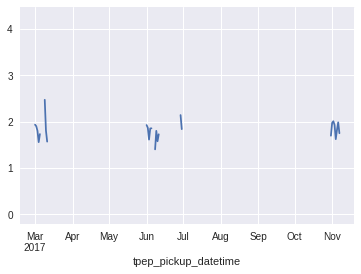

In [22]:
data.set_index('tpep_pickup_datetime')['tip_amount'].resample('D').mean().plot()

We can see there are a lot of days with no information about trips:

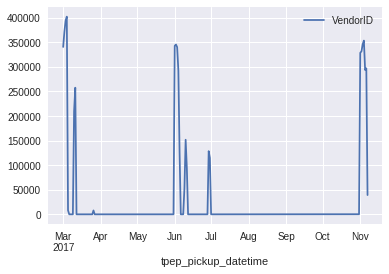

In [23]:
data.set_index('tpep_pickup_datetime')[['VendorID']].resample('D').count().plot()

Just fill that gaps with 0:

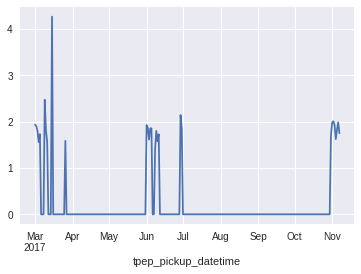

In [24]:
data.set_index('tpep_pickup_datetime')['tip_amount'].resample('D').mean().fillna(0).plot()

As the data dictionary says, tip amount is populated for credit card tips. The cash tips are not included so that trips where passengers didn't pay by credit card and the tip amount is 0 because system has no information. We could deduce the cash tips from the total amount, the fare, the distance and the trip duration but the data dictionary says the total amount does not include cash tip either. We just remove them:

In [25]:
no_creditcard = data[data['payment_type'] != 1]
no_creditcard_tip = no_creditcard[no_creditcard['tip_amount'] != 0]
no_creditcard_tip.groupby('payment_type').size()

payment_type
2     1
3    35
4    12
dtype: int64

There are trips which passengers paid by cash and there is data about the tip amount:

In [26]:
data[(data['payment_type'] == 2) & (data['tip_amount'] != 0)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
851636,1,2017-06-03 11:20:28,2017-06-03 11:24:20,3,0.4,1,N,162,229,2,4.5,0.0,0.5,1.05,0.0,0.3,6.35


In [0]:
data.loc[(data['payment_type'] == 2) & (data['tip_amount'] != 0), 'payment_type'] = 1

In [28]:
data2 = data[(data['payment_type'] == 1) | (data['tip_amount'] != 0)]
data2.groupby('payment_type').size()

payment_type
1    4052252
3         35
4         12
dtype: int64

#### Fare amount

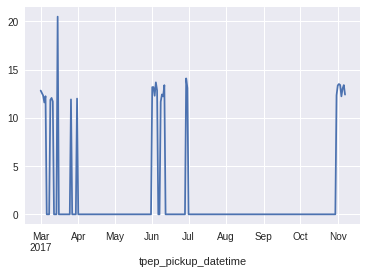

In [29]:
data.set_index('tpep_pickup_datetime')['fare_amount'].resample('D').mean().fillna(0).plot()

#### Extra

There are some features I do not really know if they are relevant so we are going to analyze them:

In [30]:
data['extra'].describe()

count    5.971881e+06
mean     3.333205e-01
std      4.471500e-01
min     -5.371000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e-01
max      6.980000e+01
Name: extra, dtype: float64

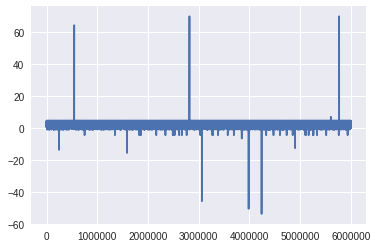

In [31]:
data['extra'].plot()

In [32]:
data.groupby(['RatecodeID', 'mta_tax']).size()

RatecodeID  mta_tax
1           -0.50         2170
             0.00          463
             0.25            1
             0.32            1
             0.35            2
             0.50      5820188
             0.85          162
             0.93            1
             7.40            1
             13.40           1
             14.48           1
             17.40           1
             46.52           1
             51.36           1
             54.51           1
2           -0.50          146
             0.00           40
             0.50       121658
             0.85           14
3            0.00        11443
             0.50            2
4           -0.50            1
             0.00            2
             0.50         2964
5           -0.50           30
             0.00         8450
             0.50         4095
6            0.50           27
99           0.00           13
             0.50            1
dtype: int64

In [33]:
data['improvement_surcharge'].describe()

count    5.971881e+06
mean     2.997234e-01
std      1.245114e-02
min     -3.000000e-01
25%      3.000000e-01
50%      3.000000e-01
75%      3.000000e-01
max      3.000000e-01
Name: improvement_surcharge, dtype: float64

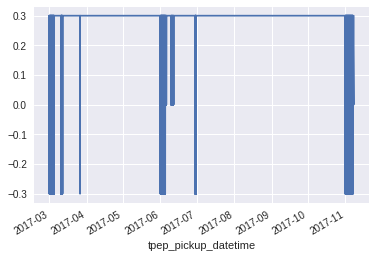

In [34]:
data.set_index('tpep_pickup_datetime')['improvement_surcharge'].plot()

There are negative values due to errors on data probably

#### Total amount

As we saw before, there are negative total amounts. This is probably due to a meter failure so we have to figure out how to fix it.

In [0]:
# TODO

## Data Summary

At this point we are are going to analyze the dataset in order to know which features are relevant. We should apply feature selection techniques but due to the dataset does not have much features and we couldn't spend a lot of time in this task we decided to skip this step. It's important to know that if we choose too few features our model underfits and when we have too many it overfits our dataset therefore will fail to generalize on the dev set. From the [data dictionary](http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf) we can figure out which features may be relevant:

*   *VendorID*: This feature **is not** relevant due to the tip amount doesn't depend on the TPEP provider
*   **tpep_pickup_datetime**: We think this feature **is** relevant because it depends on the time people usually leave more tip. Fore example, in the night when people go out.
*   **tpep_dropoff_datetime**: We think this feature **is** relevant. It tells us the trip duration.
*   **passenger_count**: We think this feature **is** relevant because the number of passengers affects the tip amount.
*   **trip_distance**: We think this feature **is** relevant. For example, the higher distances the more total amount and this affects to the tip amount.
*   *RatecodeID*: We think this feature **is not** relevant because is correlated with fare_amount which gives us more information about the final rate applied by the taxi.
*   *store_and_fwd_flag*: This feature **is not** relevant. It's information about how the meter works.
*   **PULocationID**: We think this feature **is** relevant. Taxi usually pick up people from they live so it's important to know if passengers live in rich zones.
*   **DOLocationID**: As *PULocationID* this feature **is** relevant because it gives us information where passengers want to go (shopping, bussiness, party, etc.)
*   *vpayment_type*: We think this feature **is not** relevant because we just have the tip amount of passengers who paid by credit card.
*   **fare_amount**: We think this feature **is** relevant because it tells us the final rate applied by the taxi.
*   *extra*: We think this feature **is not** relevant because it remains constant
*   *mta_tax*: We think this feature **is not** relevant because does not give any information
*   **tip_amount**: This feature **is** relevant because it is our target feature.
*   **tolls_amount**: We think this feature **is** relevant because helps us to calculate the total amount and the tip amount.
*   *improvement_surcharge*: We think this feature **is not** relevant because has a low standard desviation and remains constant in the majority of trips.
*   **total_amount**: We think this feature **is** relevant because is the final amount passengers paid (without tip).


In [0]:
relevant_features = [
  #'VendorID',
  'tpep_pickup_datetime',
  'tpep_dropoff_datetime',
  'passenger_count',
  'trip_distance',
  #'RatecodeID',
  #'store_and_fwd_flag',
  'PULocationID',
  'DOLocationID',
  #'payment_type',
  'fare_amount',
  #'extra',
  #'mta_tax',
  'tip_amount',
  'tolls_amount',
  #'improvement_surcharge',
  'total_amount' 
]

In [0]:
data = data[relevant_features]

In [38]:
print(data.shape)
data.head()

(5971881, 10)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,tolls_amount,total_amount
0,2017-11-05 23:15:41,2017-11-05 23:22:08,6,1.42,143,141,7.0,1.66,0.0,9.96
1,2017-03-04 18:25:32,2017-03-04 18:36:17,1,1.10,158,113,8.0,1.75,0.0,10.55
2,2017-06-03 14:16:15,2017-06-03 14:39:52,1,3.19,163,211,16.5,0.00,0.0,17.30
3,2017-06-04 16:16:41,2017-06-04 16:23:34,1,1.43,90,231,7.5,0.00,0.0,8.30
4,2017-03-04 17:45:09,2017-03-04 18:08:31,1,3.50,87,186,16.5,3.45,0.0,20.75


#### Relation between amount and passengers

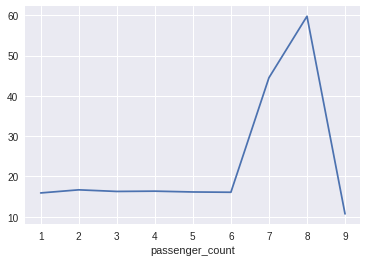

In [39]:
data.groupby(['passenger_count']).mean()['total_amount'].plot()

#### Total amount average by hour

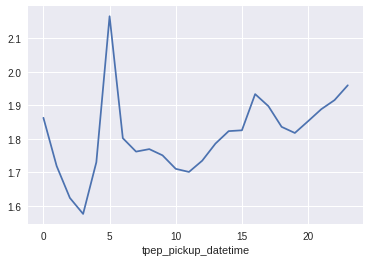

In [40]:
ds = data.set_index('tpep_pickup_datetime')
times = pd.to_datetime(ds.index)
ds['tip_amount'].groupby(times.hour).mean().plot()

## Model Building


First of all, we're going to create a new column with the trip duration in minutes and remove the drop off datetime (this operation takes several minutes to finish):

In [0]:
def get_duration_min(row):
  diff = row['tpep_dropoff_datetime'] - row['tpep_pickup_datetime']
  return diff.seconds / 60

data.loc[:, 'trip_duration'] = data.apply(lambda row: get_duration_min(row), axis=1)
data = data.drop(labels='tpep_dropoff_datetime', axis=1)

In [42]:
data.head()

,tpep_pickup_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,tolls_amount,total_amount,trip_duration
0,2017-11-05 23:15:41,6,1.42,143,141,7.0,1.66,0.0,9.96,6.450000
1,2017-03-04 18:25:32,1,1.10,158,113,8.0,1.75,0.0,10.55,10.750000
2,2017-06-03 14:16:15,1,3.19,163,211,16.5,0.00,0.0,17.30,23.616667
3,2017-06-04 16:16:41,1,1.43,90,231,7.5,0.00,0.0,8.30,6.883333
4,2017-03-04 17:45:09,1,3.50,87,186,16.5,3.45,0.0,20.75,23.366667


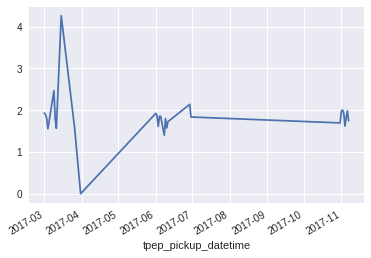

In [43]:
data.set_index('tpep_pickup_datetime')['tip_amount'].resample('D').mean().dropna().plot()

Then we create two new columns with the month and day (for boosting holidays eg.) and another with the hour because the fare and passengers depend on this.

In [0]:
data.loc[:, 'pu_date'] = data['tpep_pickup_datetime'].dt.strftime('%m-%d')

In [48]:
data.head()

,tpep_pickup_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,tolls_amount,total_amount,trip_duration,pu_date
0,2017-11-05 23:15:41,6,1.42,143,141,7.0,1.66,0.0,9.96,6.450000,11-05
1,2017-03-04 18:25:32,1,1.10,158,113,8.0,1.75,0.0,10.55,10.750000,03-04
2,2017-06-03 14:16:15,1,3.19,163,211,16.5,0.00,0.0,17.30,23.616667,06-03
3,2017-06-04 16:16:41,1,1.43,90,231,7.5,0.00,0.0,8.30,6.883333,06-04
4,2017-03-04 17:45:09,1,3.50,87,186,16.5,3.45,0.0,20.75,23.366667,03-04


In [0]:
data.loc[:, 'pu_hour'] = data['tpep_pickup_datetime'].dt.strftime('%H')
data = data.drop(labels='tpep_pickup_datetime', axis=1)

Next step we'll choose the algorithm. There are two common types of problem:

*   **Supervised Learning problems**:  All data is labeled and the algorithms learn to predict the output from the input data.

*   **Unsupervised Learning problems**: All data is unlabeled and the algorithms learn to inherent structure from the input data.


The problem is addressed by supervised learning due to we have a complete dataset with target feature we'll provide it to the algorithm. By that reason we won't use clustering nor knn. In fact, it is a regression problem because we have to predict a continuous value therefore we won't choose classification algorithms. We could use SVM if our data was lineal independient, regression trees or LSTM but [it seems to be inadvisable](https://towardsdatascience.com/the-fall-of-rnn-lstm-2d1594c74ce0) so we'll just use a MLP:


Split the dataset in input features and target feature

In [50]:
data_x = data[[c for c in data if c != 'tip_amount']]
data_y = data['tip_amount']
data_x.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tolls_amount,total_amount,trip_duration,pu_date,pu_hour
0,6,1.42,143,141,7.0,0.0,9.96,6.450000,11-05,23
1,1,1.10,158,113,8.0,0.0,10.55,10.750000,03-04,18
2,1,3.19,163,211,16.5,0.0,17.30,23.616667,06-03,14
3,1,1.43,90,231,7.5,0.0,8.30,6.883333,06-04,16
4,1,3.50,87,186,16.5,0.0,20.75,23.366667,03-04,17


In [51]:
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from sklearn.model_selection import KFold

Using TensorFlow backend.


In [52]:
def create_model():
  model = Sequential() 
  
  # Input layer with dimension 10 and hidden layer i with 128 neurons.
  model.add(Dense(128, input_dim=10, activation='relu'))
  # Dropout of 20% of the neurons and activation layer
  model.add(Dropout(.2))
  model.add(Activation("linear"))
  # Hidden layer j with 64 neurons plus activation layer
  model.add(Dense(64, activation='relu'))
  model.add(Activation("linear"))
  # Hidden layer k with 64 neurons
  model.add(Dense(64, activation='relu'))
  # Output Layer
  model.add(Dense(1))

  # Model is derived and compiled using mean square error as loss
  # function, accuracy as metric and gradient descent optimizer.
  model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])
  
  return model

'''
Training and evaluating the model
'''
def train_and_evaluate(model, train_idx, test_idx):
  np.random.seed(3)
  model.fit(data_x.iloc[train_idx], data_y.iloc[train_idx], nb_epoch=256, batch_size=2, verbose=2)
  
  predicted = model.predict(data_x.iloc[test_idx])
  pyplot.plot(y_scaler.inverse_transform(predicted), color="blue")
  pyplot.plot(y_scaler.inverse_transform(data_y.iloc[test_idx]), color="green")
  pyplot.show()


# K-Fold validation with k=7
splits = 7
kf = KFold(n_splits=splits, shuffle=True)

i = 0
for (train_idx, test_idx) in kf.split(data_x):
  print("Running Fold", i+1, "/", splits)
  model = None # Clearing the NN
  model = create_model()
  train_and_evaluate(model, train_idx, test_idx)
  i += 1


Running Fold 1 / 7


/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/256


ValueError: ignored

In order to expose the model to other systems we can create a Web Service which exposes an API RESTful and uses this model. This web service could be built using [Flask-RESTful](https://flask-restful.readthedocs.io/en/latest/) for example. In this way, we have systems with high interoperability.

The RESTful API could accepts these parameters:

*   tpep_pickup_datetime
*   trip_distance
*   passenger_count
*   PULocationID (As alternative, a lat/lon coordinates with the location colud be accepted. The systme will use the sahpefile of NYC zones in order to execute a CONTAINS spatial operation to get the zone code)
*   DOLocationID: (Like *PULocationID*, an alternative is an lat/lon coordinates with the location. The systme will use the sahpefile of NYC zones in order to execute a CONTAINS spatial operation to get the zone code)
*   fare_amount
*   tolls_amount
*   total_amount
*   trip_duration

If the company has a full dataset and wants to fill the tip amount we could develop an Spark System as ETL which uses the model developed.

**TODO**